In [1615]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sklearn

In [1616]:
def to_hours(time):
    return (time // 3600) + 6

def clean_sales_data():
    df = pd.read_csv("../data/master_data/sales_data.csv")
    sales_df = df[['token_id', 'sold_at', 'price']]
    sales_df = sales_df.rename(columns={'token_id': 'horse_id', 'sold_at': 'time_sold'}).sort_values('horse_id').reset_index(drop=True)
    sales_df['timestamp'] = sales_df['time_sold'].apply(to_hours)

    return sales_df

## Olivers merging code

In [1617]:
filenames = ['sales_and_stats_dennis_pt2.csv','sales_and_stats_dennis_pt_1_8k .csv','sales_and_stats_harper.csv', 'sales_and_stats_jason.csv']

meta_data_races = pd.read_csv("../sales_and_stats_oliver.csv")

for file in filenames:
    new_df = pd.read_csv(f'../{file}')
    meta_data_races = pd.concat([meta_data_races,new_df], axis = 0)

print(meta_data_races.shape)
meta_data_attributes = pd.read_csv("../data/master_data/backup_meta_db.csv")

# print(f"columns of meta_data_races = \n {meta_data_races.columns}")
# print(f"columns of meta_data_attributes = \n {meta_data_attributes.columns}")

merged = meta_data_attributes.copy()

meta_merged = merged.merge(meta_data_races, on = "horse_id", how = "outer").fillna(0)
meta_merged = meta_merged.drop(columns=['Unnamed: 0_y', 'Unnamed: 0_x', ])
meta_merged.columns

(51023, 11)


Index(['currency', 'price', 'sold_at', 'horse_id', 'genotype', 'bloodline',
       'breed_type', 'color', 'birthday', 'super_coat', 'mother', 'father',
       'horse_type', 'free_win_rate', 'paid_win_rate', 'place', 'total_paid',
       'win_rate', 'overall.first', 'overall.races', 'overall.second',
       'overall.third'],
      dtype='object')

In [1618]:
# replace complex token names with easier to understand names and drop rows paid for with zed_tokens

meta_merged.replace(to_replace='0x5ec03c1f7fa7ff05ec476d19e34a22eddb48acdc', value='zed_token', inplace=True)
meta_merged.replace(to_replace='0x7ceb23fd6bc0add59e62ac25578270cff1b9f619', value='eth', inplace=True)

meta_merged = meta_merged[meta_merged['currency'] != 'zed_token']
meta_merged.currency.value_counts()

#drop currency column now that price is just eth

meta_merged = meta_merged.drop(columns=['currency'])


### convert sales times to match eth price times

In [1619]:
meta_sales = meta_merged.rename(columns={'sold_at': 'time_sold'}).sort_values('horse_id').reset_index(drop=True)
meta_sales['timestamp'] = meta_sales['time_sold'].apply(to_hours)

In [1620]:
#sales_data = clean_sales_data()

In [1621]:
eth_prices = pd.read_csv('../data/master_data/eth_price_history.csv')
eth_prices.tail()

,Unnamed: 0,timestamp,eth_price
9091,9091,464923,1533.01
9092,9092,464924,1529.65
9093,9093,464925,1535.38
9094,9094,464926,1538.76
9095,9095,464927,1550.97


In [1622]:
eth_merge = pd.merge(meta_sales, eth_prices, left_on='timestamp', right_on='timestamp', how='left')
eth_merge['converted_price'] = eth_merge['price'] * eth_merge['eth_price']
clean_market_data = eth_merge.drop(columns=['Unnamed: 0', 'price', 'timestamp','eth_price'])


def to_day(unix_time):
    return datetime.date.fromtimestamp(unix_time)

clean_market_data['day_sold'] = clean_market_data['time_sold'].apply(to_day)
clean_market_data.to_csv('mega_master_db.csv')
clean_market_data

,time_sold,horse_id,genotype,bloodline,breed_type,color,birthday,super_coat,mother,father,...,paid_win_rate,place,total_paid,win_rate,overall.first,overall.races,overall.second,overall.third,converted_price,day_sold
0,1.650125e+09,27,Z1,Nakamoto,genesis,Absolute Zero,2019-01-31T03:48:43,False,0.0,0.0,...,8.20,39.37,4.786438,12.41,226,1821,254,237,60665.000,2022-04-16
1,1.657313e+09,68,Z1,Nakamoto,genesis,Slate Gray,2019-02-07T09:20:41,False,0.0,0.0,...,0.00,57.89,0.039840,13.16,5,38,5,12,13934.205,2022-07-08
2,1.657313e+09,75,Z1,Nakamoto,genesis,Slate Gray,2019-02-07T11:15:31,False,0.0,0.0,...,0.00,55.00,0.002400,20.00,4,20,5,2,9693.360,2022-07-08
3,1.657313e+09,89,Z1,Nakamoto,genesis,Slate Gray,2019-02-15T19:45:15,False,0.0,0.0,...,0.00,56.52,0.009720,21.74,5,23,3,5,9693.360,2022-07-08
4,1.663112e+09,92,Z1,Nakamoto,genesis,Champagne Papi,2019-02-16T13:09:35,False,0.0,0.0,...,13.04,38.04,0.160059,10.14,28,276,37,40,10943.775,2022-09-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74779,0.000000e+00,520344,0,0,0,0,0,0,0.0,0.0,...,11.11,20.69,0.006528,6.90,2,29,4,0,NaN,1969-12-31
74780,0.000000e+00,520345,0,0,0,0,0,0,0.0,0.0,...,0.00,27.12,0.000000,10.17,6,59,7,3,NaN,1969-12-31
74781,0.000000e+00,520346,0,0,0,0,0,0,0.0,0.0,...,14.29,30.23,0.016128,16.28,7,43,3,3,NaN,1969-12-31
74782,0.000000e+00,520404,0,0,0,0,0,0,0.0,0.0,...,10.00,25.00,0.083148,8.33,4,48,4,4,NaN,1969-12-31


### Deal with outliers

In [1623]:
# Calculate the z-score for each data point
clean_market_data['z_score'] = np.abs((clean_market_data['converted_price'] - np.mean(clean_market_data['converted_price'])) / np.std(clean_market_data['converted_price']))

clean_market_data
market_data_no_outliers = clean_market_data[clean_market_data['z_score'] < 3]
print(clean_market_data.shape, market_data_no_outliers.shape, f'=> {74911 - 74820} data points removed')

(74784, 23) (74389, 23) => 91 data points removed


In [1624]:
market_data_no_outliers

,time_sold,horse_id,genotype,bloodline,breed_type,color,birthday,super_coat,mother,father,...,place,total_paid,win_rate,overall.first,overall.races,overall.second,overall.third,converted_price,day_sold,z_score
15,1.671901e+09,270,Z1,Nakamoto,genesis,Rosy Brown,2019-03-02T09:29:40,False,0.0,0.0,...,24.63,1.760085,3.59,34,946,79,120,3046.15000,2022-12-24,2.345064
24,1.663184e+09,501,Z2,Nakamoto,genesis,Electric Violet,2019-03-15T12:08:00,False,0.0,0.0,...,22.87,0.091390,5.38,12,223,16,23,3093.96000,2022-09-14,2.384025
25,1.663610e+09,501,Z2,Nakamoto,genesis,Electric Violet,2019-03-15T12:08:00,False,0.0,0.0,...,22.87,0.091390,5.38,12,223,16,23,1801.86500,2022-09-19,1.331101
28,1.673439e+09,545,Z2,Nakamoto,genesis,Papaya Whip,2019-03-17T07:05:34,False,0.0,0.0,...,20.74,0.733313,2.82,23,815,62,84,1792.11150,2023-01-11,1.323153
37,1.655247e+09,644,Z2,Nakamoto,genesis,Brown Sugar,2019-03-20T11:32:57,False,0.0,0.0,...,24.37,0.143701,4.30,12,279,25,31,3337.74900,2022-06-14,2.582687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74761,1.673462e+09,519821,Z268,Buterin,cross,Cosmic Cobalt,2023-01-07T19:47:54,False,368861.0,509644.0,...,0.00,0.000000,0.00,0,8,0,0,1.38913,2023-01-11,0.136101
74762,1.673563e+09,519849,Z17,Buterin,elite,Oval Orchid,2023-01-07T22:27:17,False,473513.0,489756.0,...,18.18,0.000000,9.09,1,11,1,0,23.34585,2023-01-12,0.118208
74763,1.673312e+09,519892,Z12,Finney,exclusive,Midnight Black,2023-01-08T03:01:52,False,443585.0,2605.0,...,29.91,0.229800,13.08,14,107,11,7,66.24200,2023-01-09,0.083252
74764,1.673477e+09,519901,Z6,Szabo,exclusive,Dark Moss,2023-01-08T04:15:02,False,513329.0,24283.0,...,23.19,0.056379,8.70,6,69,6,4,11.20592,2023-01-11,0.128101


## Exploratory Data Analysis

### Price Distribution

<AxesSubplot: xlabel='converted_price'>

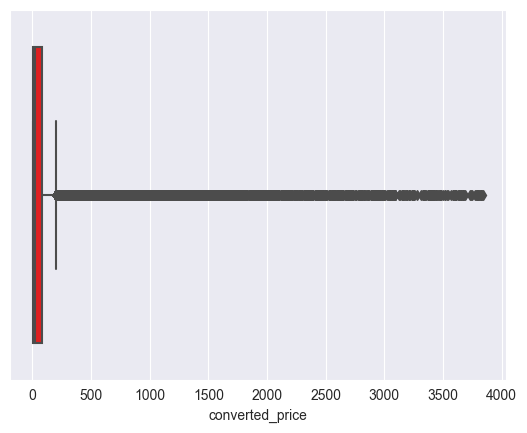

In [1625]:
sns.boxplot(data = market_data_no_outliers, x='converted_price', color='red')
# plt.xlim(0,20000)
# plt.ylim(0,80)

The distribution of prices is highly right skewed.

### Win rate vs Price

<AxesSubplot: xlabel='win_rate', ylabel='converted_price'>

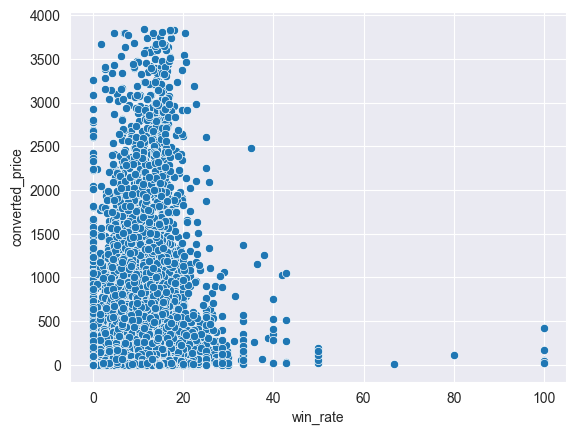

In [1626]:
sns.scatterplot(data=market_data_no_outliers, x='win_rate', y='converted_price')

### Different Factors by Breed

In [1627]:
by_breed = market_data_no_outliers.groupby('breed_type').mean().reset_index()
by_breed

C:\Users\dgnic\AppData\Local\Temp\ipykernel_27044\2959402490.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_breed = market_data_no_outliers.groupby('breed_type').mean().reset_index()


,breed_type,time_sold,horse_id,mother,father,free_win_rate,paid_win_rate,place,total_paid,win_rate,overall.first,overall.races,overall.second,overall.third,converted_price,z_score
0,cross,1.662909e+09,416312.150826,284935.210108,294491.871742,5.888686,1.907812,19.312311,0.028182,5.618649,8.681341,106.407184,8.510966,8.468373,20.078084,0.125501
1,elite,1.661447e+09,387200.217384,235481.718158,222533.164802,7.178207,3.123271,22.790164,0.066909,6.794897,15.042771,176.305422,14.992857,14.884509,31.889489,0.118140
2,exclusive,1.659331e+09,333594.173334,159520.259636,92669.891201,7.620131,3.718447,24.090492,0.137964,7.192714,23.388437,267.932164,22.976927,22.892314,84.858425,0.121940
3,genesis,1.660587e+09,21897.416488,0.000000,0.000000,7.340878,4.093276,22.616439,0.214878,6.499659,24.660580,287.462137,24.845059,24.577336,539.718844,0.338801
4,legendary,1.658653e+09,298353.971044,14577.697012,12923.873187,7.750761,3.740246,24.599530,0.170139,7.188440,25.386989,294.575179,26.212546,26.362849,189.491619,0.160817
5,pacer,1.661643e+09,415614.001215,259706.924535,313375.999635,2.594986,0.688643,10.066278,0.009770,2.519611,2.480860,53.962571,2.924778,3.225665,12.139662,0.128471


Text(0.5, 1.0, 'Mean Win Rate by Breed Type')

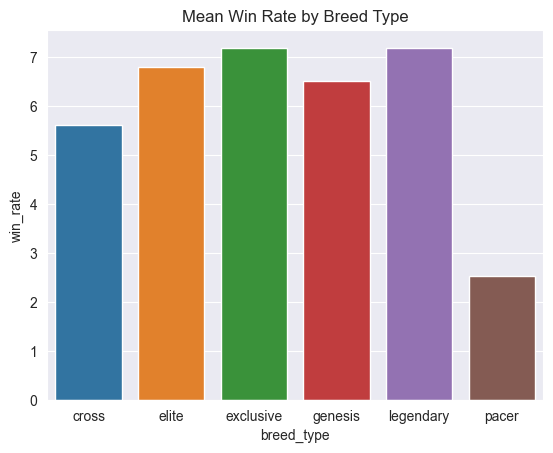

In [1628]:
sns.barplot(data=by_breed, x='breed_type', y='win_rate')
plt.title('Mean Win Rate by Breed Type')

Text(0.5, 1.0, 'Mean Number of 1st Place Finishes by Breed')

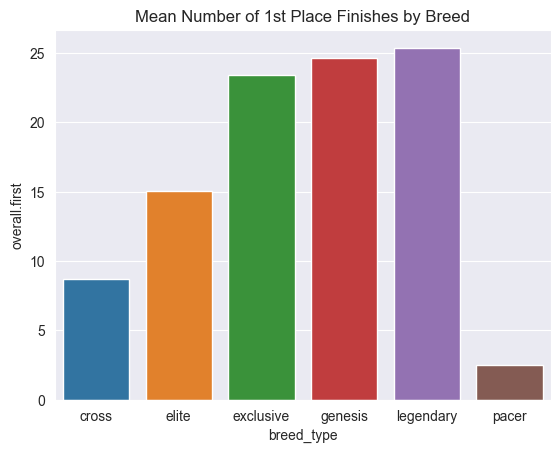

In [1629]:
sns.barplot(data=by_breed, x='breed_type', y='overall.first')
plt.title('Mean Number of 1st Place Finishes by Breed')

<AxesSubplot: xlabel='breed_type', ylabel='converted_price'>

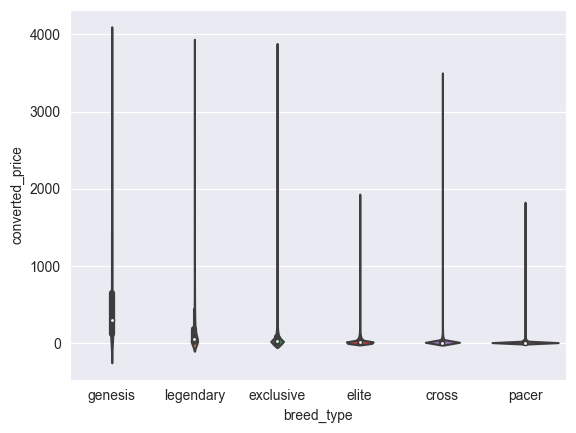

In [1630]:
sns.violinplot(data=market_data_no_outliers, x='breed_type', y='converted_price')

### Different Factors by Bloodline

In [1631]:
by_blood = market_data_no_outliers.groupby('bloodline').mean().reset_index()
by_blood

C:\Users\dgnic\AppData\Local\Temp\ipykernel_27044\880782964.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_blood = market_data_no_outliers.groupby('bloodline').mean().reset_index()


,bloodline,time_sold,horse_id,mother,father,free_win_rate,paid_win_rate,place,total_paid,win_rate,overall.first,overall.races,overall.second,overall.third,converted_price,z_score
0,Buterin,1.660381e+09,323918.589748,160738.338202,156802.056951,5.469681,2.402422,17.643384,0.057995,5.198868,13.491651,159.261847,12.583198,12.205910,47.731050,0.128035
1,Finney,1.659886e+09,328330.938158,146234.212673,113266.571546,7.317045,3.563324,23.641300,0.113920,6.937956,21.020360,243.566980,20.671128,20.600152,88.403112,0.139460
2,Nakamoto,1.660045e+09,358235.076523,136368.416797,108246.232767,8.504209,3.852216,26.919906,0.206905,7.786541,24.973531,294.052688,27.252462,27.954024,241.766624,0.172763
3,Szabo,1.659725e+09,334698.273201,136212.888102,104283.003051,8.073463,3.882477,25.563020,0.156668,7.561329,24.766066,290.052455,25.350359,25.618837,149.367392,0.148827


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Buterin'),
  Text(1, 0, 'Finney'),
  Text(2, 0, 'Nakamoto'),
  Text(3, 0, 'Szabo')])

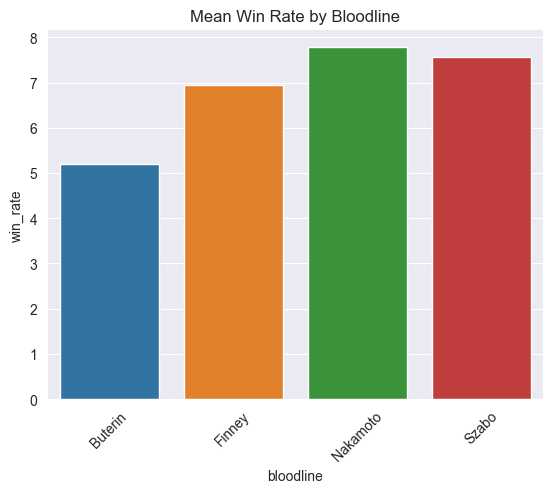

In [1632]:
sns.barplot(data=by_blood, x='bloodline', y='win_rate')
plt.title('Mean Win Rate by Bloodline')
plt.xticks(rotation = 45)

(array([19052., 19083., 19113., 19144., 19174., 19205., 19236., 19266.,
        19297., 19327., 19358.]),
 [Text(19052.0, 0, '2022-03'),
  Text(19083.0, 0, '2022-04'),
  Text(19113.0, 0, '2022-05'),
  Text(19144.0, 0, '2022-06'),
  Text(19174.0, 0, '2022-07'),
  Text(19205.0, 0, '2022-08'),
  Text(19236.0, 0, '2022-09'),
  Text(19266.0, 0, '2022-10'),
  Text(19297.0, 0, '2022-11'),
  Text(19327.0, 0, '2022-12'),
  Text(19358.0, 0, '2023-01')])

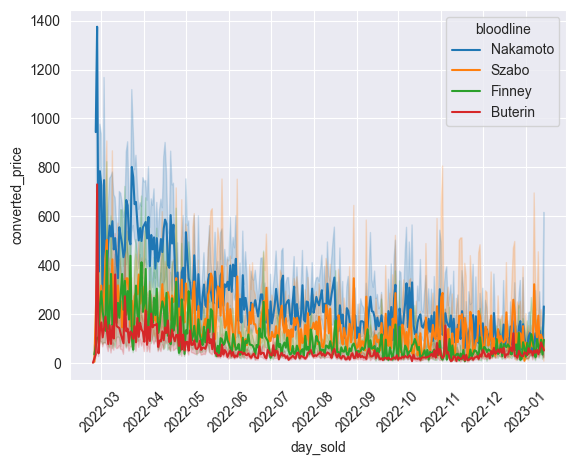

In [1633]:
sns.lineplot(data=market_data_no_outliers, x='day_sold', y='converted_price', hue= 'bloodline')
plt.xticks(rotation=45)

## Model Fitting

### Adjust for categorical variables: One-hot encoding

In [1634]:
# remove NaNs from the dataset
market_data_no_outliers = market_data_no_outliers[~pd.isna(market_data_no_outliers['converted_price'])]

In [1635]:
# clean the dataset to only include desired predictors and separate out the X and y
# X will only have continuous variables for now
X = market_data_no_outliers.drop(columns=['converted_price', 'time_sold','horse_id','birthday', 'horse_id', 'mother', 'father', 'z_score', 'day_sold','bloodline', 'breed_type', 'color', 'genotype', 'horse_type', 'super_coat'])

y = market_data_no_outliers.converted_price
X.columns

Index(['free_win_rate', 'paid_win_rate', 'place', 'total_paid', 'win_rate',
       'overall.first', 'overall.races', 'overall.second', 'overall.third'],
      dtype='object')

In [1636]:
# following accredited to ChatGPT
from sklearn.preprocessing import OneHotEncoder

# list of categorical variables:
cat_vars = [ 'breed_type','bloodline',  'genotype', 'horse_type', 'super_coat']

# one-hot encode all cat_vars
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

print(f'shape before one_hot: {X.shape}')
for var in cat_vars:
    # print(f'Overall df: {X.shape}')
    # One-hot encode the categorical variable
    categorical_variable_encoded = encoder.fit_transform(market_data_no_outliers[var].values.reshape(-1,1))

    # Convert the encoded variable to a DataFrame
    categorical_variable_encoded = pd.DataFrame(categorical_variable_encoded, columns=encoder.get_feature_names_out([var]))
    # print(f'{var}:{categorical_variable_encoded.shape}')

    # Concatenate the encoded variable with the original data
    X = pd.concat([X, categorical_variable_encoded], axis=1)
X.fillna(0, inplace=True)
X = X[:74385]
print(X.shape, y.shape)
# X.tail(10)

shape before one_hot: (74389, 9)


C:\Users\dgnic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\dgnic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\dgnic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\dgnic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocess

(74385, 293) (74389,)


### Select Model Hyperparameters

In [1637]:
# following accredited to ChatGPT

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Define the model
model = LinearRegression()

# Define the parameter grid
param_grid = {'fit_intercept': [True, False], 'positive': [True, False]}

# Create the grid search object
grid = GridSearchCV(model, param_grid, cv=5, return_train_score=True)


# Fit the grid search to the data
grid.fit(X, y)

# Print the best parameters and score
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)
print("Best estimator: ", grid.best_estimator_)
# print(f"{len(grid.feature_names_in_)} features selected out of {len(X.columns)}")
# print('Feature names:',grid.feature_names_in_)

ValueError: Found input variables with inconsistent numbers of samples: [74385, 74389]

### Test out different feature selection methods

#### Split data into test and train sets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=156,
                                   test_size=0.2,
                                   shuffle=True)

#### LassoCV
'This method works well with linear models and can be used to select both continuous and categorical predictors, it's particularly useful when there are a large number of predictors in the dataset and the goal is to select a subset of the most relevant features.' - ChatGPT

In [ ]:
# fit model using LassoCV for feature selection
from sklearn.linear_model import LassoCV

# Create an instance of LassoCV
lasso = LassoCV(cv=5)

# Fit the LassoCV model to the data
lasso.fit(X_train, y_train)

#  holdout scoring
result = lasso.score(X_test, y_test)
print("Holdout R2: %.2f%%" % (result*100.0))

# Get the selected features
selected_features = X.columns[lasso.coef_ != 0]
print(f'{len(selected_features)} features selected out of {len(X.columns)}: {", ".join(selected_features)}')

# get lasso score
# score = lasso.score(X, y)
# print(f'Model score is: {score}')



In [ ]:
# Get a single data point from the DataFrame
data_point = X.iloc[15,:]
print(data_point)

# Make a prediction for the data point
prediction = lasso.predict(data_point.values.reshape(1, -1))
print(prediction)
X

In [ ]:
# scoring with k-fold validation

from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, random_state=100, shuffle=True)
results_kfold = sklearn.model_selection.cross_val_score(lasso, X, y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0))